### Work left to do

##### 1(Abdul). Create a script that queries the Google Books API for each book in the books_data.csv dataset and retrieves the pageCount and averageRating fields from the response and adds them as columns to the enhanced_books_data.csv

##### Expected columns: book_title, page_count, average_rating 

##### 2(Joseph). Sentiment analysis of the review/text to produce a column with either a positive(1) or negative(1) sentiment; said column can be used as a feature in a ML model

##### 3. Four models have been built

###### 1. Linear regression - Joseph draft 
###### 2. K-nearest neighbors - Joseph draft 
###### 3. _ model - Brian 
###### 4. _ model - Griffin 

##### 4(everyone). Analysis and Evaluation of model performance/model comparison

##### 5(everyone). Lessons learned/things we would do differently/things we would do if we had more time 

# Everyone should be working in a single notebook. 

# Data pre-processing/filtering/cleaning

In [2]:
import re

import matplotlib.pyplot as plt

import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder

from textblob import TextBlob

books_file_path = 's3://cap4770-2024summer12/books_data.csv'
book_ratings_path = 's3://cap4770-2024summer12/Books_rating.csv'

In [3]:
books = pd.read_csv(books_file_path, usecols=["Title", "authors", "categories", "ratingsCount", "publishedDate"])
books.rename(columns={'Title': 'title', 'publishedDate': 'date_published', 'ratingsCount': 'ratings_count'}, inplace=True)

books["date_published"] = books["date_published"].str.strip()
books["date_published"] = books["date_published"].apply(lambda x: None if re.search(r'\d{4}', str(x)) is None else re.search(r'\d{4}', str(x)).group(0))
books = books.dropna()

books['date_published'] = books['date_published'].astype(int)
books = books[books["ratings_count"] >= 20]

books.head(5)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:279: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


,title,authors,date_published,categories,ratings_count
111,The Rabbi's Cat,['Joann Sfar'],2005,['Comics & Graphic Novels'],25.0
269,The Castle in the Attic,['Elizabeth Winthrop'],2012,['Juvenile Fiction'],21.0
368,Jean Paul Sartres No Exit and the Flies,['Jean-Paul Sartre'],1976,['Drama'],22.0
475,The Gods of Mars,['Edgar Rice Burroughs'],2020,['Fiction'],26.0
520,A Wise Woman,['Philippa Gregory'],1994,['Fiction'],21.0


In [4]:
book_ratings = pd.read_csv(book_ratings_path, usecols=["User_id", "Title", "Price", "review/score", "review/text", "review/summary"])
book_ratings.rename(columns={'User_id': 'user_id', 'Title': 'title', "Price": "price", 'review/score': 'rating', 'review/text': 'review_text', 'review/summary': 'review_summary'}, inplace=True)
book_ratings = book_ratings.dropna()

book_ratings.head(5)

,title,price,user_id,rating,review_summary,review_text
10,Wonderful Worship in Smaller Churches,19.40,AZ0IOBU20TBOP,5.0,Outstanding Resource for Small Church Pastors,"I just finished the book, &quot;Wonderful Wors..."
11,Wonderful Worship in Smaller Churches,19.40,A373VVEU6Z9M0N,5.0,Small Churches CAN Have Wonderful Worship,Many small churches feel like they can not hav...
12,Wonderful Worship in Smaller Churches,19.40,AGKGOH65VTRR4,5.0,Not Just for Pastors!,I just finished reading this amazing book and ...
13,Wonderful Worship in Smaller Churches,19.40,A3OQWLU31BU1Y,5.0,Small church pastor? This is the book on worship,I hadn't been a small church pastor very long ...
14,Whispers of the Wicked Saints,10.95,A3Q12RK71N74LB,1.0,not good,I bought this book because I read some glowing...


In [5]:
merged_book_attributes = books.merge(book_ratings, on='title', how='inner')\
                              .drop_duplicates(subset=['title', 'user_id'], keep=False)
                                
merged_book_attributes = merged_book_attributes[['date_published', 'ratings_count', 'price', 'review_summary', 'review_text', 'rating']]

merged_book_attributes['full_review_sentiment_score'] = merged_book_attributes['review_text'].apply(lambda review: TextBlob(review).sentiment.polarity)
merged_book_attributes['review_summary_sentiment_score'] = merged_book_attributes['review_summary'].apply(lambda review_summary: TextBlob(review_summary).sentiment.polarity)

merged_book_attributes.drop('review_summary', axis=1, inplace=True)
merged_book_attributes.drop('review_text', axis=1, inplace=True)

merged_book_attributes.head()

,date_published,ratings_count,price,rating,full_review_sentiment_score,review_summary_sentiment_score
0,2005,25.0,16.93,4.0,0.130353,0.50
1,2005,25.0,16.93,5.0,0.186603,0.65
2,2005,25.0,16.93,5.0,0.169697,0.80
3,2005,25.0,16.93,5.0,0.173779,0.60
4,2005,25.0,16.93,5.0,0.126473,0.00


In [6]:
X_train, X_test, y_train, y_test = train_test_split(merged_book_attributes[['date_published', 'ratings_count', 'price', 'full_review_sentiment_score', 'review_summary_sentiment_score']], merged_book_attributes[['rating']], test_size=0.2, random_state=42)

# Linear regression

In [7]:
regr = LinearRegression()

In [8]:
regr.fit(X_train, y_train)

LinearRegression()

In [9]:
ratings_y_pred = regr.predict(X_test)

In [10]:
print(f"Coefficients: {regr.coef_}")
print(f"Mean squared error: {mean_squared_error(y_test, ratings_y_pred)}")
print(f"Coefficient of determination: {r2_score(y_test, ratings_y_pred)}")

Coefficients: [[-9.01496703e-04 -9.04437776e-06 -1.05686742e-03  1.76443776e+00
   7.79062872e-01]]
Mean squared error: 1.1564303676171115
Coefficient of determination: 0.19250274726444172


ValueError: x and y must be the same size

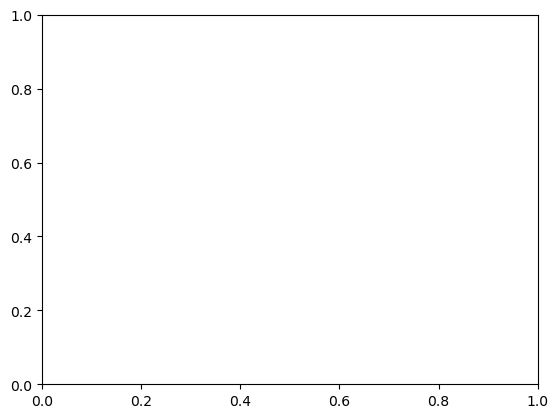

In [14]:
# plt.scatter(X_test, y_test, color="black")
# plt.xlabel('Book Price')
# plt.ylabel('Rating')
# plt.plot(X_test, ratings_y_pred, color="blue", linewidth=3)

# K-nearest neighbors 

In [11]:
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=2)

In [12]:
neigh.score(X_test, y_test)

0.004341571786620979

In [13]:
knn = KNeighborsRegressor()
param_grid = {'n_neighbors': range(1, 17), 'weights': ['uniform', 'distance']}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best r2 score:", grid_search.best_score_)

Best parameters: {'n_neighbors': 16, 'weights': 'uniform'}
Best r2 score: 0.25224819784717817
